## PURPOSE
Develop a model to predict the demand for electric power usage  on an hour by hour basis using data from 2017-02-1 to 20-01-31.

Steps:
*  Import and validate Data, including fixing any null data

*  Visualise this data to highlight any linkages betweem temperature  and power usage, as      well as any periodic impacts. Determine whether demand increasing or not
  
*  Develop a simple linear regression model(LRM) and assess it accuracy

*  Determine if this can be improved by analysing time series and develop a composite model    that improves the original
*  Use this model to predict power usage in February 2020

The main body of the notebook essentially repeats the 4 major steps of the project ..but with the inclusion of the public holidays. This was necessary after moving the project from a laptop that had insufficient memory to run the the pmdarima package. The replacement system upgraded the environment significantly and resulted in errors running the original code developed for the first four steps of the project.



# EXECUTIVE OVERVIEW
This brings together relevant information regarding the preferred model, its capabilities and limitations.
#NB The only criticism I have of the project is that (in my opinion) it needs to set a scenario which sets out the business need for the study  ie strategic or tactical, and what accuracy predictions need to be.  In real life no executive will sponsor a change unless there is a good business case ...and even then
...so I have not done a sales spin as requested in the 


In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from datetime import datetime, timedelta
from pandas.tseries.holiday import *

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Upload temperature Data to temporary DF "dftemp", convert dates, change colun headers, check results

In [2]:
dftemp = pd.read_csv("RawData/hr_temp_20170201-20200131_subset.csv", usecols=[1,4])
print( "number of data points ",len(dftemp.index))

number of data points  26280


In [3]:
dftemp.columns=['date','temp'] 


In [4]:
dftemp['date'] = pd.to_datetime(dftemp['date'],format="%Y-%m-%dT%H")


In [5]:
dftemp.dtypes



date    datetime64[ns]
temp           float64
dtype: object

In [6]:
print(dftemp.head(10))

                 date  temp
0 2017-02-01 00:53:00  37.0
1 2017-02-01 01:53:00  37.0
2 2017-02-01 02:53:00  36.0
3 2017-02-01 03:53:00  36.0
4 2017-02-01 04:53:00  36.0
5 2017-02-01 05:53:00  36.0
6 2017-02-01 06:53:00  34.0
7 2017-02-01 07:53:00  33.0
8 2017-02-01 08:53:00  34.0
9 2017-02-01 09:53:00  35.0


Upload power Data to temporary DF "b", convert dates, change column headers

In [7]:
dfload = pd.read_csv("RawData/hrl_load_metered - 20170201-20200131.csv", usecols=[1,6])
print( "number of data points ",len(dfload.index))

number of data points  26280


In [8]:
dfload.columns=['date','mw'] 
print(dfload.head(5))

            date        mw
0  2/1/2017 0:00  1419.881
1  2/1/2017 1:00  1379.505
2  2/1/2017 2:00  1366.106
3  2/1/2017 3:00  1364.453
4  2/1/2017 4:00  1391.265


In [9]:
dfload['date'] = pd.to_datetime(dfload['date'],format="%m/%d/%Y %H:%M")
dfload.dtypes

date    datetime64[ns]
mw             float64
dtype: object

In [10]:

print(dfload.head(5))

                 date        mw
0 2017-02-01 00:00:00  1419.881
1 2017-02-01 01:00:00  1379.505
2 2017-02-01 02:00:00  1366.106
3 2017-02-01 03:00:00  1364.453
4 2017-02-01 04:00:00  1391.265


Join dftemp:dfload using datetime column date

In [11]:
#dropped merge/concat as these no longer work in linux environment
df = {'mw': dfload['mw'], 'temp': dftemp['temp'], 'date': dftemp['date']}

In [12]:

#d.dtypes
d=pd.DataFrame(df)

In [13]:
print(d.head(10))
print(d.tail(10))

         mw  temp                date
0  1419.881  37.0 2017-02-01 00:53:00
1  1379.505  37.0 2017-02-01 01:53:00
2  1366.106  36.0 2017-02-01 02:53:00
3  1364.453  36.0 2017-02-01 03:53:00
4  1391.265  36.0 2017-02-01 04:53:00
5  1477.343  36.0 2017-02-01 05:53:00
6  1585.252  34.0 2017-02-01 06:53:00
7  1671.412  33.0 2017-02-01 07:53:00
8  1708.597  34.0 2017-02-01 08:53:00
9  1713.813  35.0 2017-02-01 09:53:00
             mw  temp                date
26270  1598.181  39.0 2020-01-31 14:53:00
26271  1594.159  37.0 2020-01-31 15:53:00
26272  1615.810  37.0 2020-01-31 16:53:00
26273  1650.582  35.0 2020-01-31 17:53:00
26274  1645.181  34.0 2020-01-31 18:53:00
26275  1618.484  34.0 2020-01-31 19:53:00
26276  1580.925  33.0 2020-01-31 20:53:00
26277  1545.354  33.0 2020-01-31 21:53:00
26278  1478.832  33.0 2020-01-31 22:53:00
26279  1405.188  34.0 2020-01-31 23:53:00


add date time columns


In [14]:
d['hour']= d['date'].dt.hour
d['weekday']= d['date'].dt.dayofweek
d['day']= d['date'].dt.day
d['month']= d['date'].dt.month
d['year']= d['date'].dt.year
d['phol']=0
print(d.head(5))

         mw  temp                date  hour  weekday  day  month  year  phol
0  1419.881  37.0 2017-02-01 00:53:00     0        2    1      2  2017     0
1  1379.505  37.0 2017-02-01 01:53:00     1        2    1      2  2017     0
2  1366.106  36.0 2017-02-01 02:53:00     2        2    1      2  2017     0
3  1364.453  36.0 2017-02-01 03:53:00     3        2    1      2  2017     0
4  1391.265  36.0 2017-02-01 04:53:00     4        2    1      2  2017     0


Set Public Holidays in Column "phol" to 1 when a public holiday otherwise leave 0

In [15]:

sdt = datetime(2017, 2, 1)
edt = datetime(2020, 2, 29)
print("Holidays between 2017-02-01 and 2020-02-29 using the US federal holiday calendar.")
cal = USFederalHolidayCalendar()
i=0
for dt in cal.holidays(start=sdt, end=edt): 
    print (dt.date())
    i=i+1
    dtyy=dt.year
    dtmm=dt.month
    dtdd=dt.day  
    d.loc[(d['month'] == dtmm) & (d['year']== dtyy)& (d['day']==dtdd),'phol']=1
print("number of holidays is ",i)

Holidays between 2017-02-01 and 2020-02-29 using the US federal holiday calendar.
2017-02-20
2017-05-29
2017-07-04
2017-09-04
2017-10-09
2017-11-10
2017-11-23
2017-12-25
2018-01-01
2018-01-15
2018-02-19
2018-05-28
2018-07-04
2018-09-03
2018-10-08
2018-11-12
2018-11-22
2018-12-25
2019-01-01
2019-01-21
2019-02-18
2019-05-27
2019-07-04
2019-09-02
2019-10-14
2019-11-11
2019-11-28
2019-12-25
2020-01-01
2020-01-20
2020-02-17
number of holidays is  31


In [16]:
d=d.set_index('date').asfreq('h')


In [17]:
#Check that we have correct number of public holidays in data
checkphol = d[d.phol == 1]
#print(checkphol.head(25))
print("Number of Public Holiday Modified Entries ",len(checkphol.index), "That is ", len(checkphol.index)/24, " days")

Number of Public Holiday Modified Entries  718 That is  29.916666666666668  days


In [18]:
sum(d['temp'].isnull())


63

In [19]:
sum(d['mw'].isnull())

26

In [20]:
d=d.interpolate(method='linear',limit_direction = 'both')


In [21]:
print('Number of null temp values:',sum(d['temp'].isnull()),'  Number of null mw values:',sum(d['mw'].isnull()))

Number of null temp values: 0   Number of null mw values: 0


In [22]:
d.head()

mw  temp  hour  weekday  day  month    year  phol
date                                                                        
2017-02-01 00:53:00  1419.881  37.0   0.0      2.0  1.0    2.0  2017.0   0.0
2017-02-01 01:53:00  1379.505  37.0   1.0      2.0  1.0    2.0  2017.0   0.0
2017-02-01 02:53:00  1366.106  36.0   2.0      2.0  1.0    2.0  2017.0   0.0
2017-02-01 03:53:00  1364.453  36.0   3.0      2.0  1.0    2.0  2017.0   0.0
2017-02-01 04:53:00  1391.265  36.0   4.0      2.0  1.0    2.0  2017.0   0.0

Create training and testing data :  "train",  "test" and look have a provisional look at the data

In [23]:
print("Total number of data points ",len(d.index))
print("The  data covers the following years ",d.year.unique())
train = train = pd.DataFrame(d['2017-01-01':'2019-12-31'])
test = pd.DataFrame(d['2020-01-01':'2020-01-31'])
print("Total number of data points in Train ",len(train.index))
print("Total number of data points in Test", len(test.index))


Total number of data points  26280
The  data covers the following years  [2017. 2018. 2019. 2020.]
Total number of data points in Train  25536
Total number of data points in Test 744



Visualisation of data to identify potential trends and dependencies



<AxesSubplot:title={'center':'Train:date versus power usage'}, xlabel='date'>

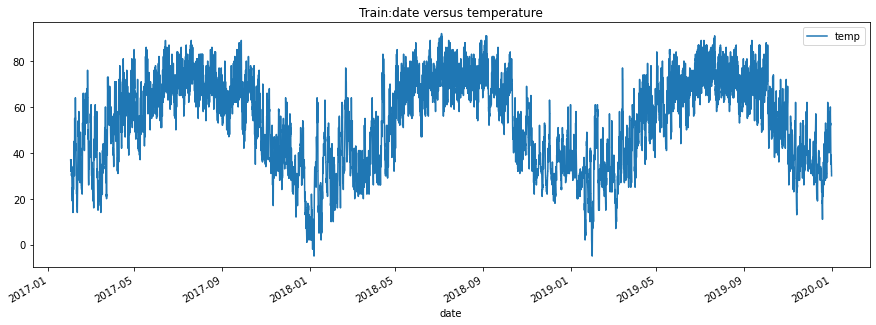

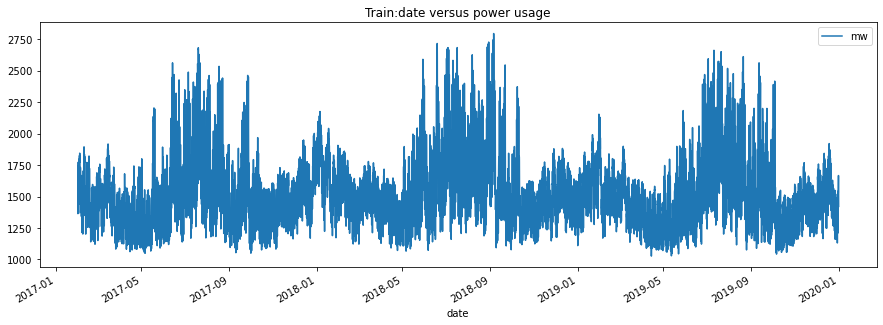

In [24]:
train.plot(kind='line',y='temp',title='Train:date versus temperature',figsize=(15, 5))  #index is used as default x axis
train.plot(kind='line',y='mw',title='Train:date versus power usage',figsize=(15, 5))  #index is used as default x axis

<AxesSubplot:title={'center':'Test:date versus power usage'}, xlabel='date'>

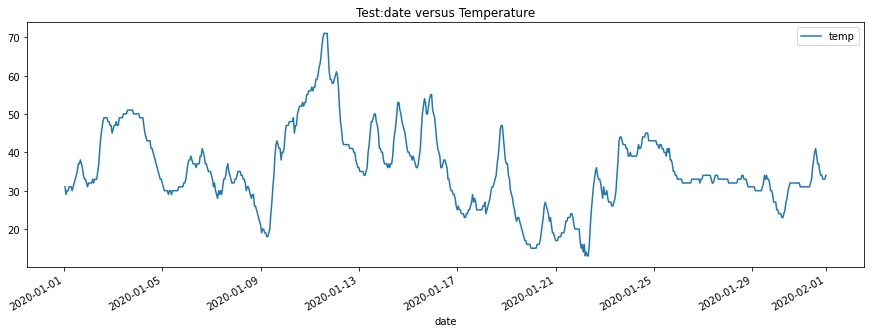

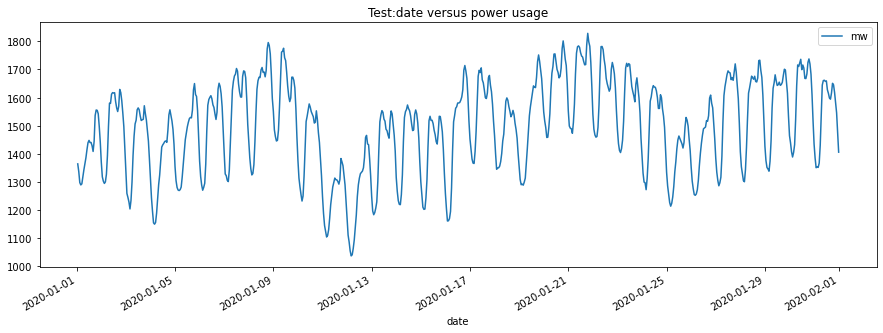

In [25]:
test.plot(kind='line',y='temp',title='Test:date versus Temperature',figsize=(15, 5))  #index is used as default x axis

test.plot(kind='line',y='mw',title='Test:date versus power usage',figsize=(15, 5))  #index is used as default x axis

In [26]:
train.to_pickle('train.pki')  # save as data set
test.to_pickle('test.pki')

The Charts above suggest that there is:-
    1) a positive correllation between temperature and power use
    2) potential seasonal and time of day variations
    

In [27]:
train_day_agg = train.groupby(['weekday','month','year']).agg(mw_median=('mw','median'),mw_max=('mw','max'),mw_sum=('mw','sum'))

Look at variation in daily use over set shows variation in days likely related to working week as well as temperature

In [28]:
print(train_day_agg.head(2))

                      mw_median    mw_max      mw_sum
weekday month year                                   
0.0     1.0   2018.0  1648.4025  1967.881  199590.301
              2019.0  1652.9030  1991.505  159009.563


<AxesSubplot:title={'center':'Power Variation by Day of week'}, xlabel='weekday,month,year'>

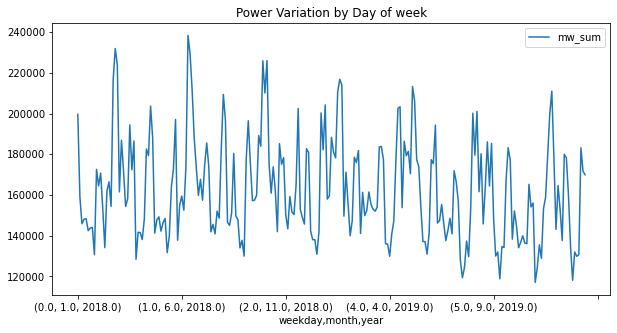

In [29]:
train_day_agg.dtypes
train_day_agg.plot(kind='line', y='mw_sum',title='Power Variation by Day of week',figsize=(10,5))

likewise looking at hour of day clearly indicates variation in keeping with tentative hypothesis of time/seasons impact usage

In [30]:
train_day_agg = train.groupby(['hour','weekday','month','year']).agg(hour_median=('mw','median'),hour_max=('mw','max'),hour_min=('mw','min'))

<AxesSubplot:title={'center':'Power Variation by hour'}, xlabel='hour,weekday,month,year'>

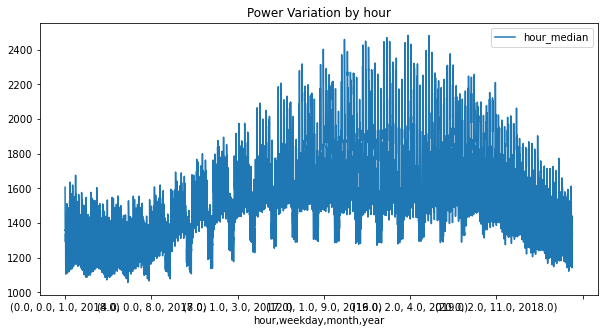

In [31]:
train_day_agg.plot(kind='line', y='hour_median',title='Power Variation by hour',figsize=(10,5))

Now lets look at useage/temperature for a week in each quarter and see how tempperature does/doesnot play a part in usage


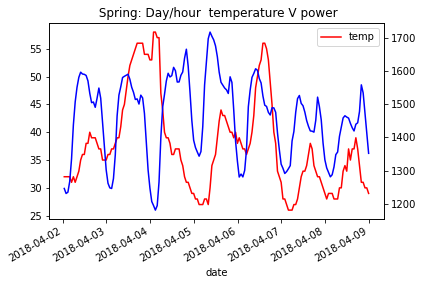

In [32]:
#Select 1st week in april  monday 2/4/2018
train_weekQ1=train.loc['2018-4-02':'2018-4-08']
fig, ax = plt.subplots()
train_weekQ1.temp.plot(ax=ax,style='r-')  #index is used as default x axis
train_weekQ1.mw.plot(ax=ax,style='b-', secondary_y=True)  #index is used as default x axis
plt.title(' Spring: Day/hour  temperature V power')
ax.legend()
 


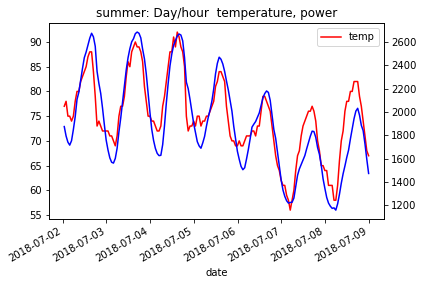

In [33]:
train_weekQ2=train.loc['2018-7-02':'2018-7-08'] #take a weeks slice in june and view correlation temp/mw
fig, ax = plt.subplots()
train_weekQ2.temp.plot(ax=ax,style='r-')  #index is used as default x axis
train_weekQ2.mw.plot(ax=ax,style='b-', secondary_y=True)  #index is used as default x axis
plt.title('summer: Day/hour  temperature, power')
ax.legend()
plt.show()

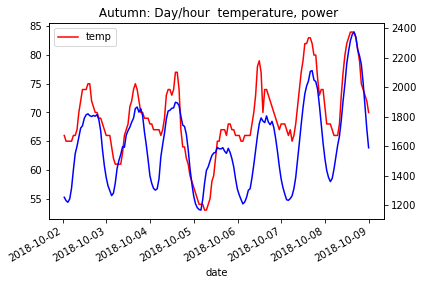

In [34]:
train_weekQ3=train.loc['2018-10-02':'2018-10-08']
fig, ax = plt.subplots()
train_weekQ3.temp.plot(ax=ax,style='r-')  #index is used as default x axis
train_weekQ3.mw.plot(ax=ax,style='b-', secondary_y=True)  #index is used as default x axis
plt.title(' Autumn: Day/hour  temperature, power')
ax.legend()
plt.show() 

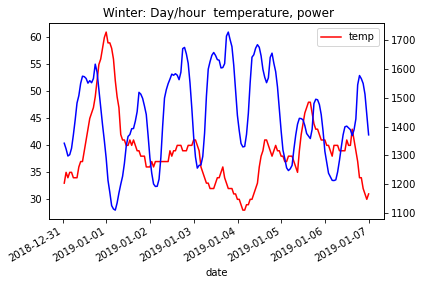

In [35]:
train_weekQ4=train.loc['2018-12-31':'2019-1-06']
fig, ax = plt.subplots()
train_weekQ4.temp.plot(ax=ax,style='r-')  #index is used as default x axis
train_weekQ4.mw.plot(ax=ax,style='b-', secondary_y=True)  #index is used as default x axis
plt.title(' Winter: Day/hour  temperature, power')
ax.legend()
plt.show() 

Summer, autumn apparent close link between power use and temperature (over 60 degrees) Winter and Spring lower temperatures have distincly lower correlation. Raises question about validity of work/non work as critical influencers on temerature v power correlation,  but not the role of time of day as an influence

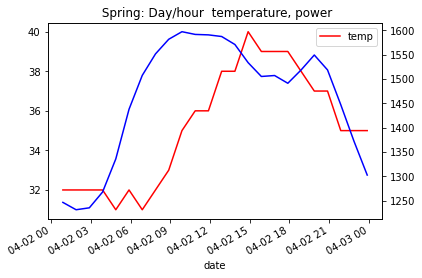

In [36]:
train_weekd1=train.loc['2018-4-02':'2018-4-02']
fig, ax = plt.subplots()
train_weekd1.temp.plot(ax=ax,style='r-')  #index is used as default x axis
train_weekd1.mw.plot(ax=ax,style='b-', secondary_y=True)  #index is used as default x axis
plt.title(' Spring: Day/hour  temperature, power')
ax.legend()
plt.show() 


                      hour_median  hour_max  hour_min  temp_max  temp_min
weekday month year                                                       
0.0     1.0   2018.0     1792.289  1967.881  1528.365      34.0       3.0
1.0     1.0   2018.0     1746.010  2095.842  1414.195      36.0       5.0


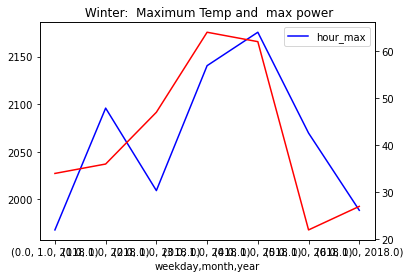

In [37]:
train_day_agg = train.loc['2018-01-01':'2018-01-14'].groupby(['weekday','month','year']).agg(hour_median=('mw','median'),hour_max=('mw','max'),hour_min=('mw','min'),temp_max=('temp','max'),temp_min=('temp','min'))
print(train_day_agg.head(2))
fig, ax = plt.subplots()
train_day_agg.hour_max.plot(ax=ax,style='b-')  #index is used as default x axis
train_day_agg.temp_max.plot(ax=ax,style='r-', secondary_y=True)  #index is used as default x axis
plt.title(' Winter:  Maximum Temp and  max power')
ax.legend()
plt.show() 

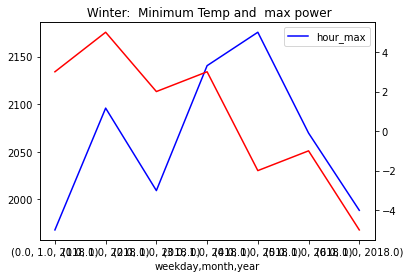

In [38]:
fig, ax = plt.subplots()
train_day_agg.hour_max.plot(ax=ax,style='b-')  #index is used as default x axis
train_day_agg.temp_min.plot(ax=ax,style='r-', secondary_y=True)  #index is used as default x axis
plt.title(' Winter:  Minimum Temp and  max power')
ax.legend()
plt.show() 

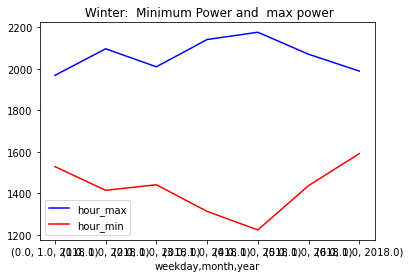

In [39]:
fig, ax = plt.subplots()
train_day_agg.hour_max.plot(ax=ax,style='b-')  #index is used as default x axis
train_day_agg.hour_min.plot(ax=ax,style='r-', secondary_y=False)  #index is used as default x axis
plt.title(' Winter:  Minimum Power and  max power')
ax.legend()
plt.show() 

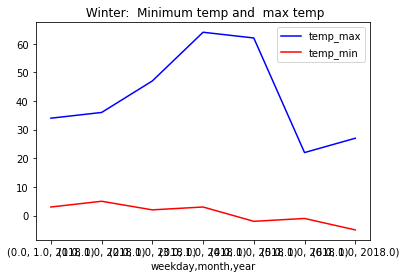

In [40]:
fig, ax = plt.subplots()
train_day_agg.temp_max.plot(ax=ax,style='b-')  #index is used as default x axis
train_day_agg.temp_min.plot(ax=ax,style='r-', secondary_y=False)  #index is used as default x axis
plt.title(' Winter:  Minimum temp and  max temp')
ax.legend()
plt.show() 

The daily variation in temperature is high in winter but the minimum is relatively constant during this period Power variation seems more related to max temperature rather than minimum (electricity not used for heating ??) There is arguably a constant minimum powerload regardless of temperature/time of week and mximum doesnt vary that much over time

Determine Correllation of temperature(temp) and Power(mw) indicates that not strongly correlated which gells with graphical evidence that high temp and time(day of week and hour) both influence power usage


In [41]:
print('Overall correlationb for Training Data ' ,train[['temp','mw']].corr() )
train_weekQ2=train.loc['2018-6-02':'2018-9-08']
print('correlation for Training Summer 2018: ',train_weekQ2[['temp','mw']].corr() )
train_weekQ4=train.loc['2018-11-02':'2019-3-08']
print('correlation for Training Winter 2018-19: ',train_weekQ4[['temp','mw']].corr() )


Overall correlationb for Training Data            temp        mw
temp  1.000000  0.327601
mw    0.327601  1.000000
correlation for Training Summer 2018:           temp       mw
temp  1.00000  0.89257
mw    0.89257  1.00000
correlation for Training Winter 2018-19:            temp        mw
temp  1.000000 -0.492732
mw   -0.492732  1.000000


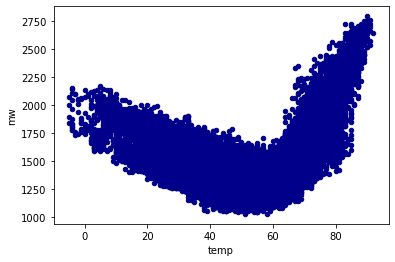

In [42]:
ax1 = train.plot.scatter(x='temp',

                      y='mw',

                      c='DarkBlue')

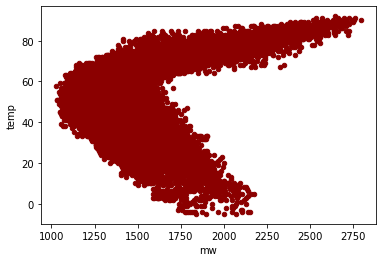

In [43]:
ax1 = train.plot.scatter(x='mw',

                      y='temp',

                      c='DarkRed')

Both these views suggest that high temperature(60F+)and below freezing (32F-) act to increase power use significantly. 

Create new column for Temp squared (tempsq) to use in model



In [44]:
train['temp_n'] = (train['temp']-train['temp'].mean())/train['temp'].std()
train['temp_nsq'] = train['temp_n']**2

In [45]:
test['temp_n'] = (test['temp']-test['temp'].mean())/test['temp'].std()
test['temp_nsq'] = test['temp_n']**2

In [46]:
train.head()

mw  temp  hour  weekday  day  month    year  phol  \
date                                                                           
2017-02-01 00:53:00  1419.881  37.0   0.0      2.0  1.0    2.0  2017.0   0.0   
2017-02-01 01:53:00  1379.505  37.0   1.0      2.0  1.0    2.0  2017.0   0.0   
2017-02-01 02:53:00  1366.106  36.0   2.0      2.0  1.0    2.0  2017.0   0.0   
2017-02-01 03:53:00  1364.453  36.0   3.0      2.0  1.0    2.0  2017.0   0.0   
2017-02-01 04:53:00  1391.265  36.0   4.0      2.0  1.0    2.0  2017.0   0.0   

                       temp_n  temp_nsq  
date                                     
2017-02-01 00:53:00 -0.871536  0.759575  
2017-02-01 01:53:00 -0.871536  0.759575  
2017-02-01 02:53:00 -0.924532  0.854759  
2017-02-01 03:53:00 -0.924532  0.854759  
2017-02-01 04:53:00 -0.924532  0.854759


# #  Correlation of MW squared with Power
Lets reexamine correlation over time and we find that correllation improves significantly
#even

In [47]:
# Lets reexamine correlation over time and we find that correllation improved significantly
#even though summer remains standout 
print('Overall correlation for Training Data T StandardisedSq')
print(train[['temp_nsq','mw']].corr())
train_weekQ2=train.loc['2018-6-02':'2018-9-08']
print('correlation for Training Summer 2018: ')
print(train_weekQ2[['temp_nsq','mw']].corr() )
train_weekQ4=train.loc['2018-11-02':'2019-3-08']
print('correlation for Training Winter 2018-19: ')
print(train_weekQ4[['temp_nsq','mw']].corr() )
#and 
print('Overall correlationb for Training Data T Standardised')
print(train[['temp_n','mw']].corr() )
train_weekQ2=train.loc['2018-6-02':'2018-9-08']
print('correlation for Training Summer 2018: ')
print(train_weekQ2[['temp_n','mw']].corr() )
train_weekQ4=train.loc['2018-11-02':'2019-3-08']
print('correlation for Training Winter 2018-19: ')
print(train_weekQ4[['temp_n','mw']].corr() )


Overall correlation for Training Data T StandardisedSq
          temp_nsq        mw
temp_nsq  1.000000  0.543123
mw        0.543123  1.000000
correlation for Training Summer 2018: 
          temp_nsq        mw
temp_nsq  1.000000  0.897721
mw        0.897721  1.000000
correlation for Training Winter 2018-19: 
          temp_nsq        mw
temp_nsq  1.000000  0.513561
mw        0.513561  1.000000
Overall correlationb for Training Data T Standardised
          temp_n        mw
temp_n  1.000000  0.327601
mw      0.327601  1.000000
correlation for Training Summer 2018: 
         temp_n       mw
temp_n  1.00000  0.89257
mw      0.89257  1.00000
correlation for Training Winter 2018-19: 
          temp_n        mw
temp_n  1.000000 -0.492732
mw     -0.492732  1.000000


INITIAL REGRESSION MODEL FOR PREDICTING POWER (mw) INCLUDING:
  normalised temp/temp squared
  impact of hour, weekday,month , hour and public holiday
#NB a model based on use of standardised temp squared was found to be less effective

In [48]:
#results = sm.OLS.from_formula('mw ~  temp_nsq*C(hour) + temp_nsq*C(month) + C(weekday)*C(hour)', 
#                            data=train).fit()
results = sm.OLS.from_formula('mw ~ temp_n*C(hour) + temp_nsq*C(hour) +  temp_nsq*C(month) + C(weekday)*C(hour) + temp_nsq*C(phol)+C(phol)*C(hour)+ C(phol)*C(day)+ C(phol)*C(month)+ C(phol)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1041.
Date:                Sat, 05 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:29:21   Log-Likelihood:            -1.4706e+05
No. Observations:               25536   AIC:                         2.948e+05
Df Residuals:                   25221   BIC:                         2.973e+05
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [49]:
#results = sm.OLS.from_formula('mw ~ temp_n*C(hour) + temp_nsq*C(hour) + temp_n*C(month) + temp_nsq*C(month) + C(weekday)*C(hour)', 
#                            data=train).fit()
results = sm.OLS.from_formula('mw ~ temp_n*C(hour) + temp_nsq*C(hour) + temp_n*C(month) + temp_nsq*C(month) + C(weekday)*C(hour) + temp_n*C(phol) + temp_nsq*C(phol)+C(phol)*C(hour)+ C(phol)*C(day)+ C(phol)*C(month)+ C(phol)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1050.
Date:                Sat, 05 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:29:22   Log-Likelihood:            -1.4651e+05
No. Observations:               25536   AIC:                         2.937e+05
Df Residuals:                   25209   BIC:                         2.963e+05
Df Model:                         326                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [50]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['mw']-train['fitted'])/train['mw'])*100
print("Training Initial Model MAPE is: ", train['APE'].mean())

Training Initial Model MAPE is:  3.3738224801956553


In [51]:
train['residuals'] = results.resid

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

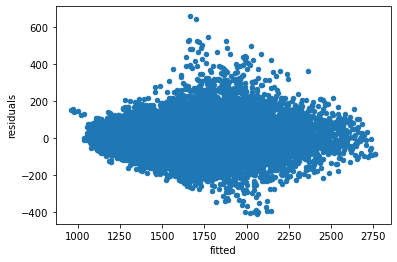

In [52]:
train.plot(x ='fitted', y='residuals', kind = 'scatter')

# Predicted mw for test data, February 

In [53]:
test['predicted'] = results.predict(test)

test.head()

mw  temp  hour  weekday  day  month    year  phol  \
date                                                                           
2020-01-01 00:53:00  1363.428  31.0   0.0      2.0  1.0    1.0  2020.0   1.0   
2020-01-01 01:53:00  1335.975  29.0   1.0      2.0  1.0    1.0  2020.0   1.0   
2020-01-01 02:53:00  1296.817  30.0   2.0      2.0  1.0    1.0  2020.0   1.0   
2020-01-01 03:53:00  1288.403  30.0   3.0      2.0  1.0    1.0  2020.0   1.0   
2020-01-01 04:53:00  1292.263  31.0   4.0      2.0  1.0    1.0  2020.0   1.0   

                       temp_n  temp_nsq    predicted  
date                                                  
2020-01-01 00:53:00 -0.435546  0.189700  1197.859311  
2020-01-01 01:53:00 -0.627915  0.394277  1182.012298  
2020-01-01 02:53:00 -0.531730  0.282737  1151.723008  
2020-01-01 03:53:00 -0.531730  0.282737  1152.667587  
2020-01-01 04:53:00 -0.435546  0.189700  1165.045289

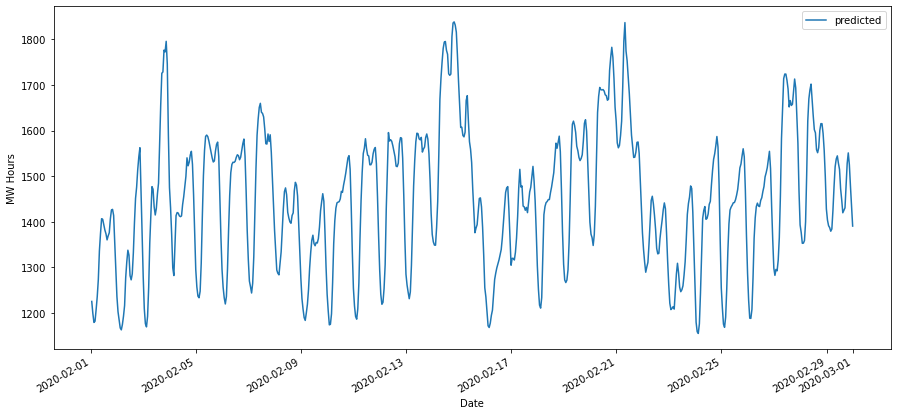

In [54]:
feb2020 = pd.read_pickle('feb2020.pki')

feb2020['predicted'] =results.predict(feb2020)
feb2020['predicted'].plot(figsize=(15,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')
plt.legend(loc="best");

plt.show()                      

# Predicted versus Actual MW test Values

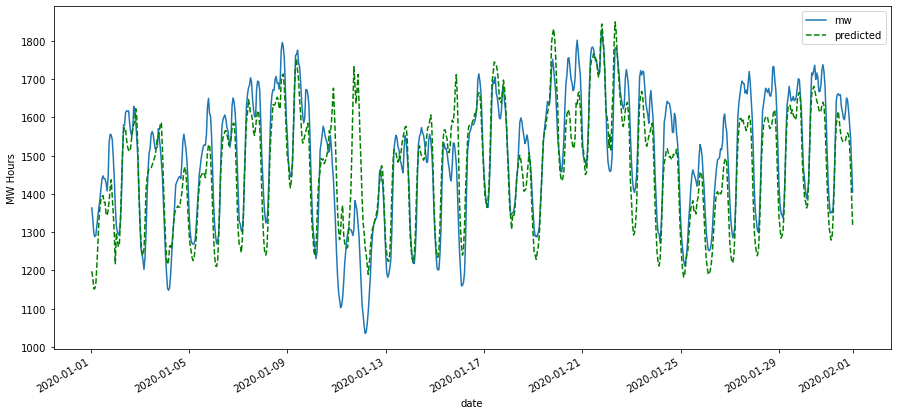

In [55]:
test['mw'].plot(figsize=(15,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['predicted'].plot(color = 'green', linestyle = 'dashed', figsize=(15,7))

plt.legend(loc="best");

plt.show()

In [56]:
test['APE'] = abs((test['mw']-test['predicted'])/test['mw'])*100
print("Initial Model MAPE is: ", test['APE'].mean())

Initial Model MAPE is:  4.4869766104474795


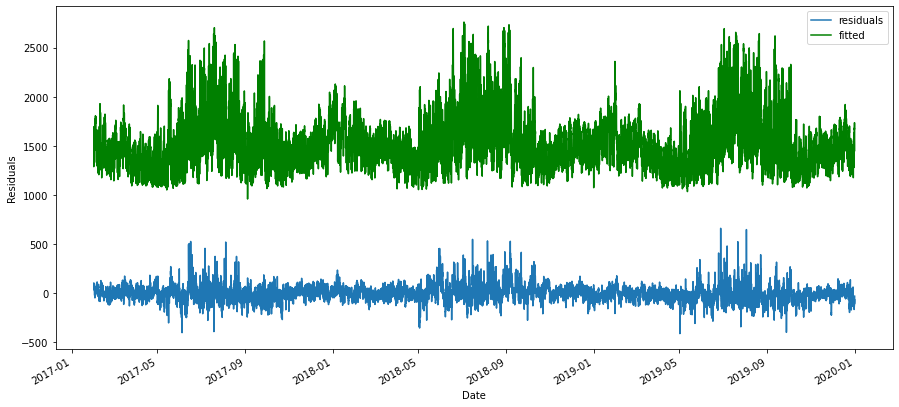

In [57]:
ax1 = train['residuals'].plot( figsize=(15,7))
ax1= train['fitted'].plot(color = 'green')
ax1.set_ylabel('Residuals')
ax1.set_xlabel('Date')
plt.legend()
plt.show()

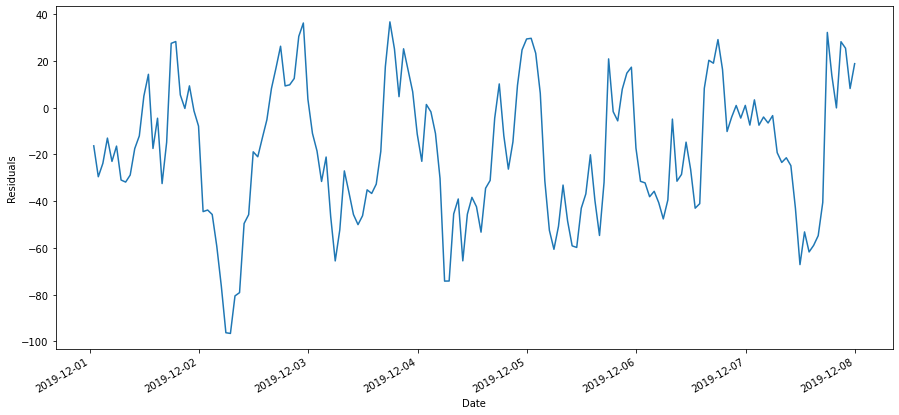

In [58]:
ax1 = train['2019-12-01':'2019-12-07']['residuals'].plot(figsize=(15,7))

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Date')

plt.show()

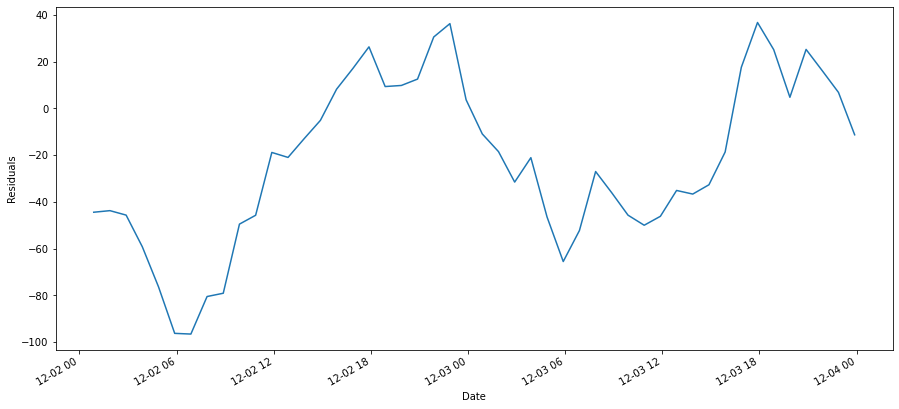

In [59]:

# Need closer look at what time of day  peaks occuring because seem to be driven by that
ax1 = train['2019-12-02':'2019-12-03']['residuals'].plot(figsize=(15,7))

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Date')

plt.show()

 # Initial Model Performance Conclusions
Appears that our model exhibits worse performance during summer period which is the time that temperature appeared to be best correlated with MW. Raises questions as to whether it has over compensated to accommodate winter. However, this proposition is not reflected in the test data results which indicate a higher residual for a winter month(January)

Highlights increased residuals as peak use grows in late afternoon. Suggests that exponential smoothing of residuals could give better results Save data first
train.to_pickle('train3Mod2.pki')
test.to_pickle('test3Mod2.pki')

In [60]:
train.to_pickle('train3Mod2.pki') 
test.to_pickle('test3Mod2.pki')

# ENHANCE MODEL BY ADDRESSING TIME SERIES issues

In [61]:

tes = ExponentialSmoothing(train.residuals, trend=None, seasonal='add', seasonal_periods=24,initialization_method='estimated')
residuals_tes = tes.fit()
print(residuals_tes.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                residuals   No. Observations:                25536
Model:             ExponentialSmoothing   SSE                       35205594.604
Optimized:                         True   AIC                         184648.452
Trend:                             None   BIC                         184860.295
Seasonal:                      Additive   AICC                        184648.515
Seasonal Periods:                    24   Date:                 Sat, 05 Jun 2021
Box-Cox:                          False   Time:                         16:29:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9245849                alpha                 True
smoothing_seasonal       

In [62]:
#LOOK AT THE RESULTS FROM SEVERAL PERSPECTIVES

forecast = pd.DataFrame(residuals_tes.forecast(744))
forecast.index = test.index.copy()
forecast.head()


0
date                          
2020-01-01 00:53:00 -35.400648
2020-01-01 01:53:00 -34.571705
2020-01-01 02:53:00 -35.820392
2020-01-01 03:53:00 -37.901351
2020-01-01 04:53:00 -40.890127

In [63]:
print("Additive Mean ",forecast.mean(), "Additive Variance: ",forecast.var())

Additive Mean  0   -37.26179
dtype: float64 Additive Variance:  0    29.25759
dtype: float64


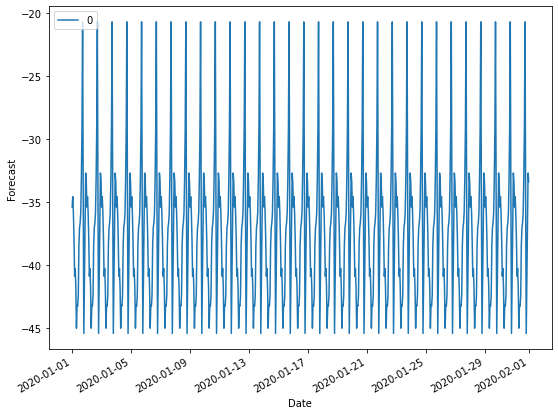

In [64]:
ax1 = forecast.plot( figsize=(9,7))

ax1.set_ylabel('Forecast')
ax1.set_xlabel('Date')

plt.show()

INICATES AN IMPROVEMENT ON OUR BASIS MODEL 
USE THIS RATHER THAN A MULTIPLICATIVE MODEL SINCE IT PERFORMED NO BETTER IN PREVIOUS ANALYSIS


In [65]:
# Add the additive es residuals to the train and test 
train['exps_residuals'] = residuals_tes.fittedvalues
test['exps_residuals'] = forecast

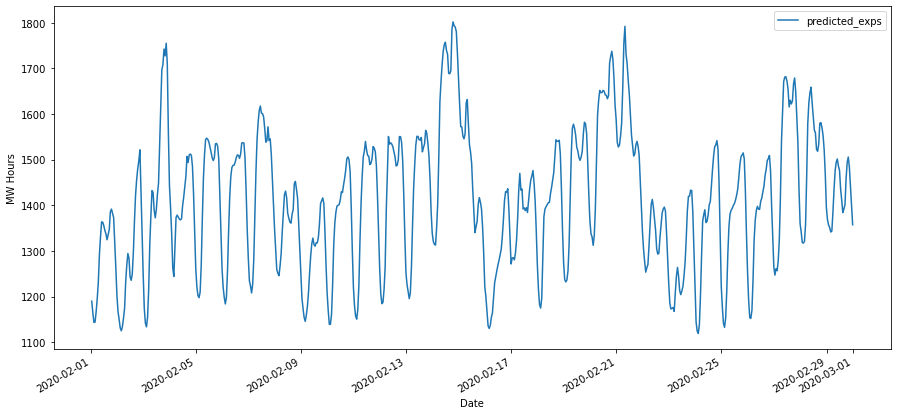

In [66]:
forecast = pd.DataFrame(residuals_tes.forecast(696))
forecast.index = feb2020.index.copy()
feb2020['exps_residuals']=forecast
feb2020['predicted_exps']=feb2020['predicted'] +feb2020['exps_residuals']
feb2020['predicted_exps'].plot(figsize=(15,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')
plt.legend(loc="best");

plt.show()  

In [67]:
feb2020

temp  hour  weekday  day  month  year  phol    temp_n  \
date                                                                         
2020-02-01 00:51:00    32     0        5    1      2  2020     0 -0.209206   
2020-02-01 01:51:00    32     1        5    1      2  2020     0 -0.209206   
2020-02-01 02:51:00    32     2        5    1      2  2020     0 -0.209206   
2020-02-01 03:51:00    32     3        5    1      2  2020     0 -0.209206   
2020-02-01 04:51:00    31     4        5    1      2  2020     0 -0.309280   
...                   ...   ...      ...  ...    ...   ...   ...       ...   
2020-02-29 19:51:00    25    19        5   29      2  2020     0 -0.909724   
2020-02-29 20:51:00    25    20        5   29      2  2020     0 -0.909724   
2020-02-29 21:51:00    25    21        5   29      2  2020     0 -0.909724   
2020-02-29 22:51:00    24    22        5   29      2  2020     0 -1.009798   
2020-02-29 23:51:00    23    23        5   29      2  2020     0 -1.109872   

                     temp_nsq    predicted  exps_residuals  predicted_exps  
date                                                                        
2020-02-01 00:51:00  0.043767  1225.149841      -35.400648     1189.749193  
2020-02-01 01:51:00  0.043767  1198.831417      -34.571705     1164.259712  
2020-02-01 02:51:00  0.043767  1179.048655      -35.820392     1143.228263  
2020-02-01 03:51:00  0.043767  1181.727540      -37.901351     1143.826189  
2020-02-01 04:51:00  0.095654  1207.121592      -40.890127     1166.231465  
...                       ...          ...             ...             ...  
2020-02-29 19:51:00  0.827598  1551.017199      -45.428434     1505.588765  
2020-02-29 20:51:00  0.827598  1524.821706      -41.024149     1483.797558  
2020-02-29 21:51:00  0.827598  1477.746775      -35.921778     1441.824998  
2020-02-29 22:51:00  1.019692  1436.010560      -32.694233     1403.316327  
2020-02-29 23:51:00  1.231816  1390.460709      -33.366987     1357.093722  

[696 rows x 12 columns]

In [68]:
train['fitted_exps'] = train['fitted'] + train['exps_residuals']
test['predicted_exps'] = test['predicted'] + test['exps_residuals']


In [69]:
train[['mw','fitted','residuals','exps_residuals','fitted_exps']]

mw       fitted   residuals  exps_residuals  \
date                                                                     
2017-02-01 00:53:00  1419.881  1317.474582  102.406418       64.665780   
2017-02-01 01:53:00  1379.505  1288.725083   90.779917       96.356223   
2017-02-01 02:53:00  1366.106  1290.674508   75.431492       88.798889   
2017-02-01 03:53:00  1364.453  1299.585756   64.867244       74.689082   
2017-02-01 04:53:00  1391.265  1346.635781   44.629219       68.147430   
...                       ...          ...         ...             ...   
2019-12-31 19:53:00  1606.134  1714.284213 -108.150213     -105.362414   
2019-12-31 20:53:00  1565.014  1669.028519 -104.014519     -103.551561   
2019-12-31 21:53:00  1515.905  1604.024890  -88.119890      -98.954382   
2019-12-31 22:53:00  1474.519  1534.854285  -60.335285      -85.809401   
2019-12-31 23:53:00  1421.717  1452.686892  -30.969892      -62.755215   

                     fitted_exps  
date                              
2017-02-01 00:53:00  1382.140363  
2017-02-01 01:53:00  1385.081306  
2017-02-01 02:53:00  1379.473397  
2017-02-01 03:53:00  1374.274838  
2017-02-01 04:53:00  1414.783211  
...                          ...  
2019-12-31 19:53:00  1608.921798  
2019-12-31 20:53:00  1565.476958  
2019-12-31 21:53:00  1505.070508  
2019-12-31 22:53:00  1449.044884  
2019-12-31 23:53:00  1389.931677  

[25536 rows x 5 columns]

In [70]:
test[['mw','predicted','exps_residuals','predicted_exps']]

mw    predicted  exps_residuals  predicted_exps
date                                                                      
2020-01-01 00:53:00  1363.428  1197.859311      -35.400648     1162.458664
2020-01-01 01:53:00  1335.975  1182.012298      -34.571705     1147.440593
2020-01-01 02:53:00  1296.817  1151.723008      -35.820392     1115.902616
2020-01-01 03:53:00  1288.403  1152.667587      -37.901351     1114.766236
2020-01-01 04:53:00  1292.263  1165.045289      -40.890127     1124.155161
...                       ...          ...             ...             ...
2020-01-31 19:53:00  1618.484  1553.690330      -45.428434     1508.261896
2020-01-31 20:53:00  1580.925  1526.585694      -41.024149     1485.561546
2020-01-31 21:53:00  1545.354  1464.920036      -35.921778     1428.998259
2020-01-31 22:53:00  1478.832  1387.587007      -32.694233     1354.892775
2020-01-31 23:53:00  1405.188  1315.700583      -33.366987     1282.333597

[744 rows x 4 columns]

In [71]:
train['APE_exps'] = abs((train['mw']-train['fitted_exps'])/train['mw'])*100
print("Combined TRAIN Least Squared and Exponential Squared Model MAPE is: ", train['APE_exps'].mean())

Combined TRAIN Least Squared and Exponential Squared Model MAPE is:  1.4822768680445195


In [72]:
test['APE_exps'] = abs((test['mw']-test['predicted_exps'])/test['mw'])*100
print("Combined TEST Least Squared and Exponential Squared  Prediction Model MAPE is: ", test['APE_exps'].mean())

Combined TEST Least Squared and Exponential Squared  Prediction Model MAPE is:  5.823643639917271


# model performance

Performance improved against Training Data but  was worse for test data (initial regression model was 4.486976610447551.. Alternative is to use SARIMAX model to fit the Initial Regression Model's data residuals

In [73]:
mod = SARIMAX(train['residuals'], order=(2,0,0), seasonal_order=(0,1,1,24))
arima_results = mod.fit()

print(arima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            residuals   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -127063.943
Date:                              Sat, 05 Jun 2021   AIC                         254135.886
Time:                                      16:31:00   BIC                         254168.474
Sample:                                  02-01-2017   HQIC                        254146.424
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8051      0.003    266.816      0.000       0.799       0.811
ar.L2          0.07

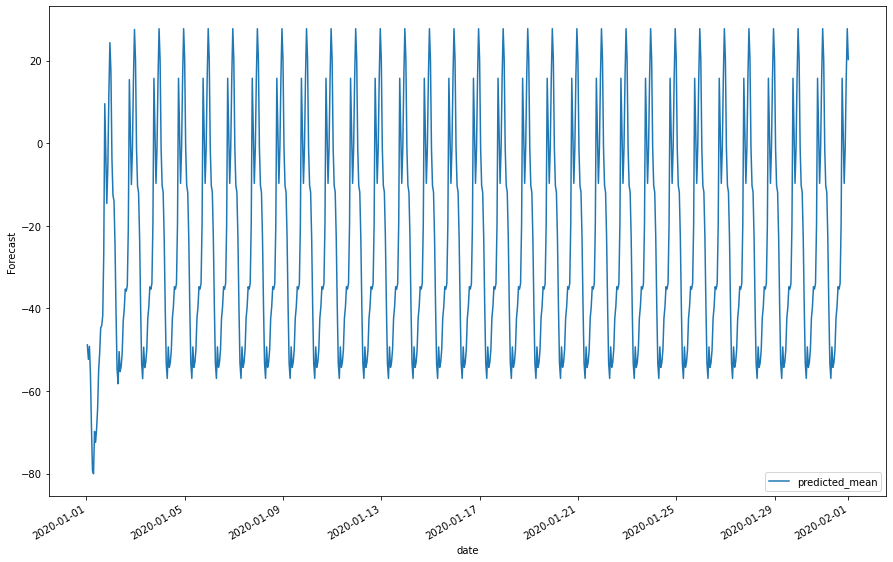

In [74]:
forecast = pd.DataFrame(arima_results.forecast(744))
forecast.index = test.index.copy()

ax1 = forecast.plot( figsize=(15,10))

ax1.set_ylabel('Forecast')

plt.show()

In [75]:
train['ARIMA_residuals'] = arima_results.predict()
test['ARIMA_residuals'] = forecast

febforecast = pd.DataFrame(arima_results.forecast(696))
febforecast.index = feb2020.index.copy()
feb2020['ARIMA_residuals'] = febforecast



In [76]:
train['fitted_ARIMA'] = train['fitted'] + train['ARIMA_residuals']
test['predicted_ARIMA'] = test['predicted'] + test['ARIMA_residuals']
feb2020['predicted_ARIMA'] = feb2020['predicted'] + feb2020['ARIMA_residuals']

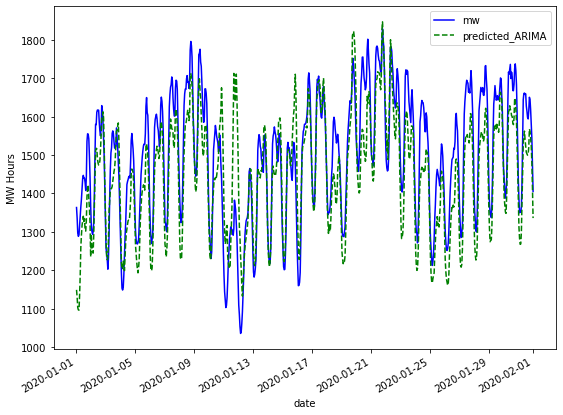

In [77]:
test['mw'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['predicted_ARIMA'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

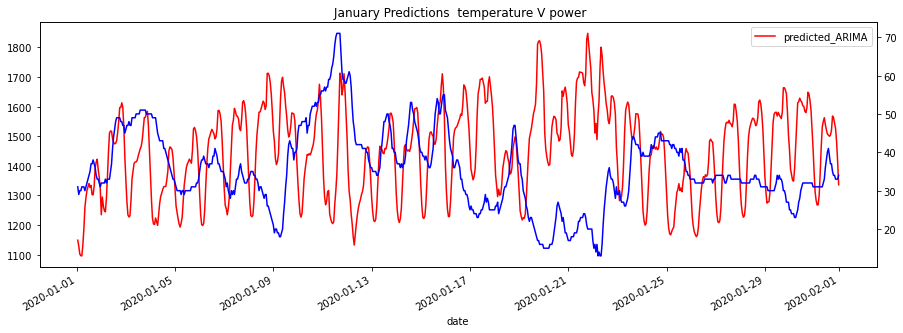

In [78]:
# Check that variations coincide with cold extremes and they do
fig, ax = plt.subplots(figsize=(15,5))
test.predicted_ARIMA.plot(x='day',ax=ax,style='r-')
test.temp.plot(x='day',ax=ax,style='b-', secondary_y=True)  
plt.title(' January Predictions  temperature V power')
ax.legend()
plt.show()

CHECK MAPE VALUES FOR TRAINinG AND TEST DATA. THE COMBINED LEAST SQUARES AND EXPONENTIAL SMOOTHING MODEL HAD VALUES:
   TRAIN:  1.4822735383299552
   TEST:   5.82355734
    
AS CAN BE SEEN FROM THE RESULTS BELOW THERE IS A MARGINAL IMPROVEMENT IN
THE COMBINED LEAST SQUARES AND ARIMA MODELS ABILITY TO FIT THE TRAINing data and to PREDICT THE
TEST DATA

In [79]:
train['APE_ARIMA'] = abs((train['mw']-train['fitted_ARIMA'])/train['mw'])*100
print("Training Initial + ARIMA Model MAPE is: ", train['APE_ARIMA'].mean())

Training Initial + ARIMA Model MAPE is:  1.364758977927712


In [80]:
test['APE_ARIMA'] = abs((test['mw']-test['predicted_ARIMA'])/test['mw'])*100
print("Test Initial+ ARIMA Model MAPE is: ", test['APE_ARIMA'].mean())

Test Initial+ ARIMA Model MAPE is:  5.423409563924176


In [81]:
train['fitted_ensemble'] = 0.5*train['fitted_exps'] + 0.5*train['fitted_ARIMA']
test['predicted_ensemble'] =  0.5*test['predicted_exps'] + 0.5*test['predicted_ARIMA']

In [82]:
train['APE_ensemble'] = abs((train['mw']-train['fitted_ensemble'])/train['mw'])*100
print("Initial + Ensemble Model MAPE is: ", train['APE_ensemble'].mean())

Initial + Ensemble Model MAPE is:  1.3795421119523594


In [83]:
test['APE_ensemble'] = abs((test['mw']-test['predicted_ensemble'])/test['mw'])*100
print("Initial + Ensemble Model MAPE is: ", test['APE_ensemble'].mean())

Initial + Ensemble Model MAPE is:  5.581624565887069


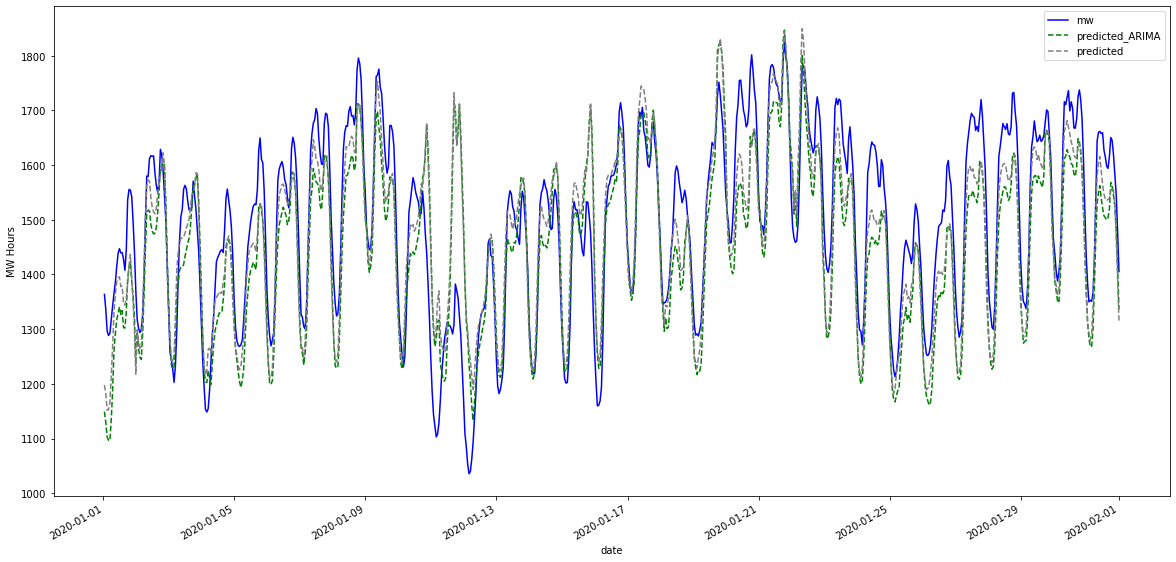

In [85]:

test['mw'].plot(color = 'blue', figsize=(20,10))
plt.ylabel('MW Hours')
plt.xlabel('Date')

test['predicted_ARIMA'].plot(color = 'green', linestyle = 'dashed', figsize=(20,10))
test['predicted'].plot(color = 'grey', linestyle = 'dashed', figsize=(20,10))
plt.legend(loc="best");

plt.show()

Check that our public holiday model is working by looking at the performance of the model for Christmas Day 2019.  The ARIMA performs best but there is some question about its accuracy in the first hours of the day.

In [86]:
publicholiday = pd.DataFrame(train.loc['2019-12-25'])

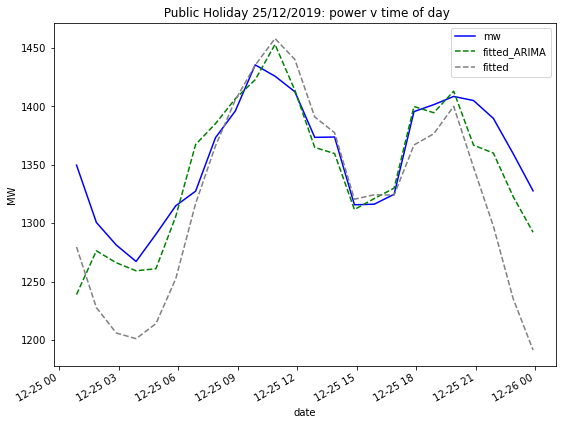

In [87]:
publicholiday['mw'].plot(color = 'blue', figsize=(9,7))
plt.ylabel('MW')
plt.xlabel('hour')
plt.title(' Public Holiday 25/12/2019: power v time of day')
publicholiday['fitted_ARIMA'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))
publicholiday['fitted'].plot(color = 'grey', linestyle = 'dashed', figsize=(9,7))
plt.legend(loc="best");
plt.show()

In [88]:
publicholiday['APE_ensemble'] = abs((publicholiday['mw']-publicholiday['fitted_ensemble'])/publicholiday['mw'])*100
print("Initial + Ensemble Model MAPE is: ", publicholiday['APE_ensemble'].mean())

Initial + Ensemble Model MAPE is:  1.3836372119514422


Just run a confirmation on the test data for the January 20 holiday ...will use all prediction models. It underpredicts actual power with the ARIMA model marginally worse

In [89]:
publicholiday = pd.DataFrame(test.loc['2020-01-20'])

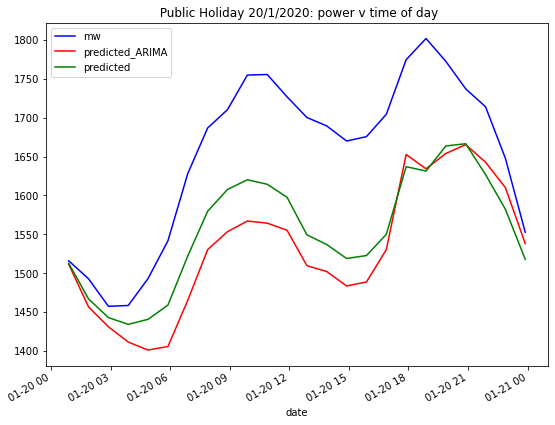

In [90]:
fig, ax = plt.subplots(figsize=(9,7))
publicholiday.mw.plot(x='hours',ax=ax,style='b-')
publicholiday.predicted_ARIMA.plot(x='hours',ax=ax,style='r-') 
publicholiday.predicted.plot(x='hours',ax=ax,style='g-') 
plt.title(' Public Holiday 20/1/2020: power v time of day')
ax.legend()
 

In [91]:
train.to_pickle('train3Mod3.pki') 
test.to_pickle('test3Mod3.pki')

In [92]:
# clean up training and Test Data to remove data from rejected  smooothing model 
train.drop(columns =['fitted_exps','fitted_ensemble','exps_residuals','APE_exps','APE_ensemble'])
test.drop(columns=['predicted_exps','predicted_ensemble','exps_residuals','APE_exps','APE_ensemble'])

mw  temp  hour  weekday   day  month    year  phol  \
date                                                                            
2020-01-01 00:53:00  1363.428  31.0   0.0      2.0   1.0    1.0  2020.0   1.0   
2020-01-01 01:53:00  1335.975  29.0   1.0      2.0   1.0    1.0  2020.0   1.0   
2020-01-01 02:53:00  1296.817  30.0   2.0      2.0   1.0    1.0  2020.0   1.0   
2020-01-01 03:53:00  1288.403  30.0   3.0      2.0   1.0    1.0  2020.0   1.0   
2020-01-01 04:53:00  1292.263  31.0   4.0      2.0   1.0    1.0  2020.0   1.0   
...                       ...   ...   ...      ...   ...    ...     ...   ...   
2020-01-31 19:53:00  1618.484  34.0  19.0      4.0  31.0    1.0  2020.0   0.0   
2020-01-31 20:53:00  1580.925  33.0  20.0      4.0  31.0    1.0  2020.0   0.0   
2020-01-31 21:53:00  1545.354  33.0  21.0      4.0  31.0    1.0  2020.0   0.0   
2020-01-31 22:53:00  1478.832  33.0  22.0      4.0  31.0    1.0  2020.0   0.0   
2020-01-31 23:53:00  1405.188  34.0  23.0      4.0  31.0    1.0  2020.0   0.0   

                       temp_n  temp_nsq    predicted        APE  \
date                                                              
2020-01-01 00:53:00 -0.435546  0.189700  1197.859311  12.143559   
2020-01-01 01:53:00 -0.627915  0.394277  1182.012298  11.524370   
2020-01-01 02:53:00 -0.531730  0.282737  1151.723008  11.188471   
2020-01-01 03:53:00 -0.531730  0.282737  1152.667587  10.535167   
2020-01-01 04:53:00 -0.435546  0.189700  1165.045289   9.844568   
...                       ...       ...          ...        ...   
2020-01-31 19:53:00 -0.146992  0.021607  1553.690330   4.003356   
2020-01-31 20:53:00 -0.243177  0.059135  1526.585694   3.437184   
2020-01-31 21:53:00 -0.243177  0.059135  1464.920036   5.204889   
2020-01-31 22:53:00 -0.243177  0.059135  1387.587007   6.170072   
2020-01-31 23:53:00 -0.146992  0.021607  1315.700583   6.368359   

                     ARIMA_residuals  predicted_ARIMA  APE_ARIMA  
date                                                              
2020-01-01 00:53:00       -48.835640      1149.023671  15.725387  
2020-01-01 01:53:00       -52.337905      1129.674394  15.441951  
2020-01-01 02:53:00       -49.179332      1102.543676  14.980782  
2020-01-01 03:53:00       -55.860252      1096.807335  14.870787  
2020-01-01 04:53:00       -68.900161      1096.145128  15.176313  
...                              ...              ...        ...  
2020-01-31 19:53:00        -9.726579      1543.963750   4.604324  
2020-01-31 20:53:00        -1.101862      1525.483833   3.506882  
2020-01-31 21:53:00        15.885696      1480.805733   4.176924  
2020-01-31 22:53:00        27.731609      1415.318617   4.294834  
2020-01-31 23:53:00        20.276797      1335.977381   4.925364  

[744 rows x 15 columns]

In [93]:
feb2020[['temp','predicted_ARIMA']]

temp  predicted_ARIMA
date                                      
2020-02-01 00:51:00    32      1176.314201
2020-02-01 01:51:00    32      1146.493512
2020-02-01 02:51:00    32      1129.869323
2020-02-01 03:51:00    32      1125.867288
2020-02-01 04:51:00    31      1138.221432
...                   ...              ...
2020-02-29 19:51:00    25      1541.290620
2020-02-29 20:51:00    25      1523.719845
2020-02-29 21:51:00    25      1493.632471
2020-02-29 22:51:00    24      1463.742169
2020-02-29 23:51:00    23      1410.737506

[696 rows x 2 columns]

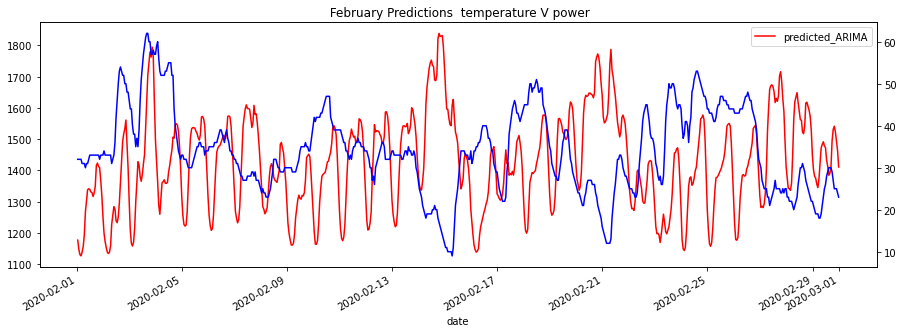

In [94]:
# Comparative temperature Power for February prediction to check power used increases when cold extremes

fig, ax = plt.subplots(figsize=(15,5))
feb2020.predicted_ARIMA.plot(x='day',ax=ax,style='r-')
feb2020.temp.plot(x='day',ax=ax,style='b-', secondary_y=True)  
plt.title(' February Predictions  temperature V power')
ax.legend()
plt.show()

# EXECUTIVE OVERVIEW
The recommended model is one that combines the least squares regression and ARIMA time series smoothing of that model's rsesiduals. It demonstrated a 1.4% accuracy with the training data as shown in the interactive plot below. It seems to be consistents with the data that suggests that power use increases with extreme cold and extreme heat, but is driven by social/time dependencies otherwise.

The model was not as effective in predicting the test data as can be seen below in second plot. Its overall accuracy is 5.5%. The third plot below predicts the MW  for February 2020, including the holiday of 2020-02-17

If the model is to be used to predict future usage, say for power supply bidding or plant use to meet demand then it is assumed that weekly weather forecasts would be used as inpput data. Obviously, the latter have their own errors and those errors would be need to be taken into account when using the power use model for business decision making. 

The three plots below also include the simple regression model's results for comparison purposes (fitted and predicted) These can be removed from the plots by clicking on the ledgend line

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
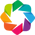

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [95]:
from hvplot import hvPlot
import holoviews as hv
hv.extension('bokeh')

plot = hvPlot(train)
plot(y=['mw', 'fitted_ARIMA', 'fitted'])

In [96]:
plot = hvPlot(test)
plot(y=['mw', 'predicted_ARIMA', 'predicted'])

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [97]:
plot = hvPlot(feb2020)
plot(y=['predicted_ARIMA', 'predicted'])

:NdOverlay   [Variable]
   :Curve   [date]   (value)